In [2]:
from qiskit import QuantumCircuit
from qiskit.tools.visualization import circuit_drawer

import matplotlib.pyplot as plt
import random, math
import numpy as np

In [6]:
from qiskit.circuit.library import *
g = RGate(0,0)
g.num_qubits
print(g.params)
print(HGate().params)

[0, 0]
[]


In [2]:
def plot_list(float_list, x_label=None, y_label=None):
    """plots a list of floats (between 0 and 1)"""
    if type(float_list[0])==list:
        x_axis = [i+1 for i in range(len(float_list[0]))]
        for j in range(len(float_list)):
            plt.plot(x_axis, float_list[-(j+1)], linewidth=20/(20+len(float_list)))
    else:
        x_axis = [i+1 for i in range(len(float_list) + 1)]
        plt.plot(x_axis, float_list)
    
    while len(x_axis) > 20:
        x_axis = [(i+1)*5 for i in range(len(x_axis)//5 + 1)]
    plt.xticks([0]+x_axis)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)

    try:
        max_value = max(1, max(float_list))
    except:
        max_value = max([max(float_list[i]) for i in range(len(float_list))]+[1])
    plt.ylim([0,max_value])
    plt.yticks([x/10 for x in range(1+math.ceil(10*max_value))])
    plt.show()

#plot_list([[0.0,0.1,0.2,0.3],[0.1,0.2,1.3,0.4],[0.2,0.3,1.4,0.5],[0.3,0.4,0.5,0.6]])

In [3]:
GLOBAL_GATE_SET = [{'label':'had','inputs':1},
                   {'label':'not','inputs':1},
                   {'label':'cnot','inputs':2},
                   {'label':'phase','inputs':1},
                   {'label':'t','inputs':1},
                   {'label':'t_prime','inputs':1},
                   {'label':'chad','inputs':2},
                   {'label':'cphase','inputs':2}]

GLOBAL_GATE_SET_SIMPLE = [{'label':'had','inputs':1},
                          {'label':'cnot','inputs':2},
                          {'label':'t','inputs':1},
                          {'label':'t_prime','inputs':1}]

def all_gate_combinations(gate_set, qubit_count=3):
    double_input_combinations = []
    for i in range(qubit_count):
        other = list(range(qubit_count))
        other.remove(i)
        for j in other:
            double_input_combinations.append(str(i)+str(j))

    all_gates = []
    for index, gate in enumerate(gate_set):
        if gate['inputs']==1:
            for q in range(qubit_count):
                all_gates.append(str(index)+str(q))
        elif gate['inputs']==2:
            for q in double_input_combinations:
                all_gates.append(str(index)+str(q))
    return all_gates

ALL_POSSIBLE_GATES = all_gate_combinations(GLOBAL_GATE_SET)


In [4]:
def construct_gate(c_instance, genotype, gate_set=GLOBAL_GATE_SET):
    """construct gate from genotype"""
    g_label = gate_set[int(genotype[0])]['label']
    
    if g_label=='cnot':
        c_instance.cx(int(genotype[1]),int(genotype[2]))
    elif g_label=='had':
        c_instance.h(int(genotype[1]))
    elif g_label=='not':
        c_instance.x(int(genotype[1]))
    elif g_label=='phase':
        c_instance.p(math.pi/2,int(genotype[1]))
    elif g_label=='t':
        c_instance.t(int(genotype[1]))
    elif g_label=='t_prime':
        c_instance.tdg(int(genotype[1]))
    elif g_label=='chad':
        c_instance.ch(int(genotype[1]),int(genotype[2]))
    elif g_label=='cphase':
        c_instance.cp(math.pi/2,int(genotype[1]),int(genotype[2]))
        
    return c_instance

In [5]:
def genotype_to_circuit(circuit_instance, genotype, gate_set):
    """decodes a string genotype to circuit form"""
    for k in genotype_to_list(genotype, gate_set):
        gate = int(k[0])
        if len(k)-1 != gate_set[gate]['inputs']:
            print('ERROR')
        circuit_instance = construct_gate(circuit_instance, k, gate_set)
    return circuit_instance

def genotype_to_list(genotype, gate_set):
    """takes a genotype and splits based on number of
       arguments per gate, rather than a separator"""
    out = []
    i = 0
    while i<len(genotype):
        gate = genotype[i]
        j = i + gate_set[int(gate)]['inputs'] + 1
        k = genotype[i:j]
        i = j
        out.append(k)
    return out

In [6]:
def generate_random_genotype(qubit_count, gate_set, min_length=15, max_length=45, falloff='linear'):#, input_count_weighted=True):
    gradient = -1/(max_length-min_length)
    intercept = -max_length*gradient
    g = ''
    while True:
        #if input_count_weighted:
        g += random_gate_input_weighted(qubit_count, gate_set)
        #else:
        #    g += random_gate_uniform(qubit_count, gate_set)
        if falloff=='linear':
            if random.random() > intercept + gradient*len(g):
                break
        elif falloff=='logarithmic':
            if random.random() > math.log10(1-9*(len(g)-max_length)/(max_length-min_length)):
                break
        elif falloff=='reciprocal':
            if random.random() > min_length/len(g):
                break
        else:
            if len(g) > max_length:
                break
    return g

'''import time
time_start = time.time()
for i in range(100):
    generate_random_genotype(3,gate_set,falloff=None)
t_delta = time.time() - time_start
print(f'    weighted: {t_delta:0.5f}s')
time_start = time.time()
for i in range(100):
    generate_random_genotype(3,gate_set,falloff=None,input_count_weighted=False)
t_delta = time.time() - time_start
print(f'non-weighted: {t_delta:0.5f}s')'''

def random_gate_uniform(qubit_count, gate_set):
    gate = random.randint(0,len(gate_set)-1)
    inputs = []
    while len(inputs) < gate_set[gate]['inputs']:
        x = str(random.randint(0,qubit_count-1))
        if x not in inputs:
            inputs.append(x)
    return str(gate) + ''.join(inputs)

def random_gate_input_weighted(qubit_count, gate_set):
    #expected_count = len(filter(lambda g: g['inputs']==1, gate_set))*qubit_count
    #expected_count += len(filter(lambda g: g['inputs']==2, gate_set))*(qubit_count**2-qubit_count)
    #if len(ALL_GATES)!=expected_count:
    #    ALL_GATES = all_gate_combinations()
    return random.choice(ALL_POSSIBLE_GATES)

final genotype: 01110220140004070252


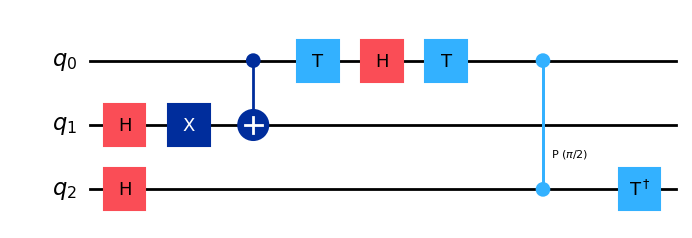

In [7]:
n = 3

c_instance = QuantumCircuit(n)
g = generate_random_genotype(n, GLOBAL_GATE_SET)
print(f'final genotype: {g}')
c_instance = genotype_to_circuit(c_instance, g, GLOBAL_GATE_SET)
c_instance.draw(output='mpl',style='iqp')

#genotype_to_list('2022105151014132525211720')

In [8]:
def random_circuit(qubit_count, gate_set, min_len=25, max_len=100, random_falloff='logarithmic'):
    '''generates a random genotype and produces the ciruit for it'''
    c_instance = QuantumCircuit(qubit_count)
    g = generate_random_genotype(qubit_count, gate_set, min_length=min_len, max_length=max_len, falloff=random_falloff)
    #print(f'final genotype: {g}')
    #print(genotype_to_list(g))
    c_instance = genotype_to_circuit(c_instance, g, gate_set)
    c_instance.draw(output='mpl',style='iqp')
    return g, c_instance

#for _ in range(10):
#    print(random_circuit(n, gate_set))
#    print('\n\n')

### Toffoli Gate
#### Truth Table and Logic Gate Representation

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 1], [1, 1, 0]]


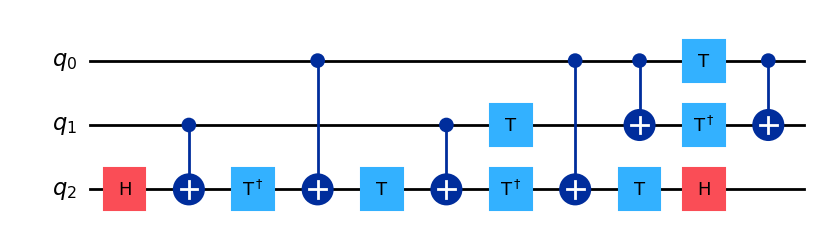

In [9]:
toffoli_inputs = [[i//4 %2, i//2 %2, i%2] for i in range(8)]
toffoli_outputs = []
for i in range(8):
    x = toffoli_inputs[i].copy()
    if bool(x[0]) and bool(x[1]):
        x[2] = int(not bool(x[2]))
    toffoli_outputs.append(x)
    
print(toffoli_inputs)
print(toffoli_outputs)
# inverted: '002105022040210502204140221004251201'
toffoli_circuit = genotype_to_circuit(QuantumCircuit(3), '022125220242212522024142201024051201', GLOBAL_GATE_SET)
toffoli_circuit.draw(output='mpl',style='iqp')
#toffoli_circuit.draw()

#### Calculates Mean Square Fidelity for above circuit (approx. 1)

In [10]:
from qiskit.quantum_info import Operator, Statevector
#from qiskit.visualization import array_to_latex

basis_vectors = [np.array([[1],[0]]), np.array([[0],[1]])]


def list_to_state(x):
    #return np.kron(np.kron(basis_vectors[x[0]],basis_vectors[x[1]]),basis_vectors[x[2]])
    return Statevector.from_int(x[2]*4+x[1]*2+x[0], 2**3)

def fidelity(psi_1, psi_2):
    #return abs(np.inner(np.transpose(psi_2), np.transpose(psi_1)).item())
    return abs(np.inner(psi_1.data, psi_2.data).item())

def msf(circuit, input_states, output_states):
    '''mean square fidelity function over a set of input and output states'''
    M = Operator(circuit)
    fidelity_sum = 0
    case_count = min(len(input_states),len(output_states))
    for i in range(case_count):
        state = input_states[i]
        calc_state = state.evolve(M)
        '''
        if fidelity(output_states[i],calc_state.data) == 0:
            print(f'input: {i}')
            j = np.where(output_states[i].data == 1)[0][0]
            print(f'expected out: {j}')
            j = np.where(np.around(calc_state.data) == 1.0)[0][0]
            print(f'calculated out: {j}')
        '''
        if calc_state==output_states[i]:
            fidelity_sum += 1.0 + 1/(2**(2*circuit.num_qubits))
        else:
            fidelity_sum += fidelity(output_states[i],calc_state.data)**2
    return fidelity_sum/case_count

def toffoli_msf(circuit):
    return msf(circuit, [list_to_state(x) for x in toffoli_inputs], [list_to_state(y) for y in toffoli_outputs])

print('base msf:')
m = toffoli_msf(toffoli_circuit)
print(m)

base msf:
1.015625


#### Generates random circuits, finds best fitness (MSF) and displays

In [11]:
SAMPLE_SIZE = 20
GENERATION_COUNT = 50
GENERATION_SIZE = 100

def remove_duplicates(genotype_list):
    '''efficient way to do this for non-hashable objects??'''
    seen_genotypes = []
    out = []
    for i in range(len(genotype_list)):
        if genotype_list[i]['genotype'] not in seen_genotypes:
            seen_genotypes.append(genotype_list[i]['genotype'])
            out.append(genotype_list[i])
    return out

def top_n_by_fitness(population, n=SAMPLE_SIZE, prefer_short_circuits=False, prefer_long_circuits=False, remove_dupe=True):
    if remove_dupe:
        population = remove_duplicates(population)
    by_fitness = sorted(population, key=lambda x: x['msf'], reverse=True)
    if prefer_short_circuits == prefer_long_circuits:
        return by_fitness[:n]
    else:
        #return sorted(by_fitness, key=lambda x: x['circuit'].depth(), reverse=prefer_long_circuits)
        return sorted(by_fitness, key=lambda x: len(x['genotype']), reverse=prefer_long_circuits)

In [ ]:
msf_trace = [[] for i in range(SAMPLE_SIZE)]
population = []

for generation in range(GENERATION_COUNT):
    for _ in range(GENERATION_SIZE):
        g, c = random_circuit(n, GLOBAL_GATE_SET, min_len=30, max_len=45, random_falloff='linear')
        m = toffoli_msf(c)
        population.append({'genotype':g, 'circuit':c, 'msf':m})
    # sort population by fitness, take top 5
    population = top_n_by_fitness(population)
    # each run compares the 100 new programs with the
    # 5 carried forward from the previous generation
    print(f'Generation {generation+1} best: {population[0]["genotype"]}')
    for x in range(SAMPLE_SIZE):
        msf_trace[x].append(population[x]['msf'])

s = min(SAMPLE_SIZE, len(population))
print(f'top {s}:')
for i in range(s):
    print(population[i]['genotype'])
    print(population[i]['msf'])

print('best random circuit:')
#population[0]['circuit'].draw(output='mpl',style='iqp')
print(population[0]['circuit'])

plot_list(msf_trace, 'Generations', 'MSF')


### Stochastic Hill Climbing

In [ ]:
""" # blank circuit
best_genotype = {
    'genotype': '1010',
    'msf': msf(genotype_to_circuit(QuantumCircuit(3),'1010'),
               [list_to_state(x) for x in toffoli_inputs],
               [list_to_state(y) for y in toffoli_outputs])
}
"""
best_genotype = {'genotype':'','msf':0.0}
msf_trace = []

for generation in range(GENERATION_COUNT):
    population = []
    for _ in range(GENERATION_SIZE):
        g, c = random_circuit(n, GLOBAL_GATE_SET, min_len=30, max_len=45, random_falloff='linear')
        m = toffoli_msf(c)
        m_delta = m - best_genotype['msf']
        if m_delta > 0:
            # only take better circuits
            population.append({'genotype':g, 'circuit':c, 'msf':m, 'msf_delta':m_delta})


    if len(population) > 0:
        population = top_n_by_fitness(population)
        # select a random genotype, using the msf improvements as weights
        best_genotype = random.choices(population, weights=[x['msf_delta'] for x in population], k=1)[0]
        best_genotype.pop('msf_delta')

    print(f'Generation {generation+1} best: {best_genotype["genotype"]}')
    msf_trace.append(best_genotype['msf'])


print('best random circuit:')
print(best_genotype['circuit'])
print(best_genotype['msf'])
#best_genotype['circuit'].draw(output='mpl',style='iqp')

plot_list(msf_trace, 'Generations', 'MSF')



In [12]:
def crossover(g_1, g_2, gate_set, uniform=True):
    '''computes the random crossover of two genotypes
       point is selected separately on each genotype, allowing for length variations'''
    g_1_list = genotype_to_list(g_1, gate_set)
    if len(g_1_list) <= 1:
        g_1_split = 0
    else:
        g_1_split = random.randint(1,len(g_1_list)-1)
    g_2_list = genotype_to_list(g_2, gate_set)
    if len(g_2_list) <= 1:
        g_2_split = 0
    else:
        g_2_split = random.randint(1,len(g_2_list)-1)
    if g_1_split == 0 and g_2_split == 0:
        return g_1, g_2
    else:
        if uniform:
            g_1_split = g_2_split = min(g_1_split, g_2_split)
        out_1 = g_1_list[:g_1_split] + g_2_list[g_2_split:]
        out_2 = g_2_list[:g_2_split] + g_1_list[g_1_split:]
        return ''.join(out_1), ''.join(out_2)

crossover('41212415231411151324140112125050310022041314100',
          '403120241304220112513150515032111211524151201',
          GLOBAL_GATE_SET)

('412124152304220112513150515032111211524151201',
 '40312024131411151324140112125050310022041314100')

In [13]:
def mutation(g, gate_set, qubit_count=3):
    '''mutates a genotype by either chosing a different gate from
       the given gate set, or modifying one of the gate inputs'''
    g_list = genotype_to_list(g, gate_set)
    g_mutation_point = random.randint(0,len(g_list)-1)
    gate = g_list[g_mutation_point]
    prev_gate = gate
    while gate==prev_gate:
        if random.random() < 0.5:
            # mutate gate
            # print('mutate gate')
            new_gate = random.randint(0,len(gate_set)-1)
            #if gate_set[new_gate]['inputs'] > gate_set[int(gate[0])]['inputs']:
            gate = str(new_gate) + prev_gate[1:]
            # check length
            expected_len = gate_set[int(gate[0])]['inputs']+1
            if len(gate) > expected_len:
                # print('mutate gate: truncating inputs')
                # truncate extra inputs
                gate = gate[:expected_len]
            else:
                while len(gate) < gate_set[new_gate]['inputs']+1:
                    # print('mutate gate: adding inputs')
                    # add inputs to satify new gate
                    new_input = str(random.randint(0,qubit_count-1))
                    if str(new_input) not in gate[1:]:
                        gate += str(new_input)
        else:
            # mutate an input
            # print('mutate input')
            new_input = random.randint(0,qubit_count-1)
            if len(gate)==2:
                gate = prev_gate[0] + str(new_input)
            else:
                index_to_change = random.randint(1,len(gate)-1)
                if str(new_input) not in prev_gate[1:index_to_change] + prev_gate[index_to_change+1:]:
                    # adds new input if not a duplicate
                    # print('inserting new input')
                    gate = prev_gate[:index_to_change] + str(new_input) + prev_gate[index_to_change+1:]

    g_list[g_mutation_point] = gate
    return ''.join(g_list)

"""
c = genotype_to_circuit(QuantumCircuit(3),'4121220112513150515032111211524151201')
print(c)
working_genotype = '4121220112513150515032111211524151201'
for _ in range(10):
    working_genotype = mutation(working_genotype, gate_set, 3)
    #print(genotype_to_list(working_genotype))
    print(genotype_to_circuit(QuantumCircuit(3),working_genotype))
"""


"\nc = genotype_to_circuit(QuantumCircuit(3),'4121220112513150515032111211524151201')\nprint(c)\nworking_genotype = '4121220112513150515032111211524151201'\nfor _ in range(10):\n    working_genotype = mutation(working_genotype, gate_set, 3)\n    #print(genotype_to_list(working_genotype))\n    print(genotype_to_circuit(QuantumCircuit(3),working_genotype))\n"

In [14]:
def insertion(g, gate_set, qubit_count=3):
    '''inserts a new random gate at a randomly chosen point in the genotype'''
    new_gate = random.randint(0,len(gate_set)-1)
    g_add = str(new_gate)
    inputs = []
    while len(inputs) < gate_set[new_gate]['inputs']:
        # generates the right number of inputs
        x = str(random.randint(0,qubit_count-1))
        if x not in inputs:
            inputs.append(x)
    g_add += ''.join(inputs)
    #print(g_add)

    # insert at random position
    g_list = genotype_to_list(g, gate_set)
    g_add_index = random.randint(0,len(g_list)-1)
    return ''.join(g_list[:g_add_index]) + g_add + ''.join(g_list[g_add_index:])

def deletion(g, gate_set):
    '''removes a random gate from the genotype'''
    g_list = genotype_to_list(g, gate_set)
    if len(g_list)<=1:
        return g
    g_remove_index = random.randint(0,len(g_list)-1)
    return ''.join(g_list[:g_remove_index] + g_list[g_remove_index+1:])

"""
c = genotype_to_circuit(QuantumCircuit(3),'41212201125131505150')
print(c)
working_genotype = '41212201125131505150'
for _ in range(5):
    working_genotype = insertion(working_genotype, gate_set, 3)
    print(genotype_to_circuit(QuantumCircuit(3),working_genotype))
    working_genotype = deletion(working_genotype)
    print(genotype_to_circuit(QuantumCircuit(3),working_genotype))
"""

"\nc = genotype_to_circuit(QuantumCircuit(3),'41212201125131505150')\nprint(c)\nworking_genotype = '41212201125131505150'\nfor _ in range(5):\n    working_genotype = insertion(working_genotype, gate_set, 3)\n    print(genotype_to_circuit(QuantumCircuit(3),working_genotype))\n    working_genotype = deletion(working_genotype)\n    print(genotype_to_circuit(QuantumCircuit(3),working_genotype))\n"

In [15]:
def develop_circuits_uniform(inital_population, gate_set, alpha=3, beta=3, gamma=3):
    '''use a prespecified distribution of search operators
    population should be sorted by msf'''
    #print(inital_population)
    population = [x['genotype'] for x in inital_population]
    # crossover operation for every pair of genotypes in the sample
    for g_1_index in range(len(inital_population)):
        for g_2_index in range(g_1_index+1,len(inital_population)):
            for c in range(gamma):
                g_3, g_4 = crossover(population[g_1_index],population[g_2_index], gate_set)
                population.append(g_3)
                population.append(g_4)
    # mutation operation for every genotype in the sample
    # insertion/deletion for each genotype in the sample
    for g_1_index in range(len(inital_population)):
        for a in range(alpha):
            g_2 = g_3 = g_4 = population[g_1_index]
            for b in range(beta):
                g_2 = mutation(g_2, gate_set)
                g_3 = insertion(g_3, gate_set)
                g_4 = deletion(g_4, gate_set)
                for g in [g_2, g_3, g_4]:
                    population.append(g)
    return population

def develop_circuits_random(inital_population, gate_set, operation_count=200, alpha=2, beta=3, gamma=2):
    '''use a random assortment of search operators'''
    population = [x['genotype'] for x in inital_population]
    for o in range(operation_count):
        # randomly select from the search operators
        operation = random.choices(population=['crossover', 'mutation', 'insersion', 'deletion'],weights=[0.4,0.5,0.05,0.05], k=1)[0]
        # randomly select a genotype (wieghted?)
        g_1 = random.choices(inital_population, weights=[x['msf'] for x in inital_population], k=1)[0]['genotype']
        if operation == 'crossover':
            g_2 = g_1
            while g_2 == g_1:
                g_2 = random.choices(inital_population, weights=[x['msf'] for x in inital_population], k=1)[0]['genotype']
            for c in range(gamma):
                g_3, g_4 = crossover(g_1, g_2, gate_set)
                population.append(g_3)
                population.append(g_4)
        else:
            if operation=='mutation':
                for a in range(alpha):
                    g_2 = g_1
                    for b in range(beta):
                        g_2 = mutation(g_2, gate_set)
                        population.append(g_2)
            elif operation=='insersion':
                for a in range(alpha):
                    g_2 = g_1
                    for b in range(beta):
                        g_2 = insertion(g_2, gate_set)
                        population.append(g_2)
            elif operation=='deletion':
                for a in range(alpha):
                    g_2 = g_1
                    for b in range(beta):
                        g_2 = deletion(g_2, gate_set)
                        population.append(g_2)
    return population

def develop_circuits_combined(inital_population, gate_set, operation_count=250):
    population_uniform = develop_circuits_uniform(inital_population, gate_set)#[len(inital_population):]
    #print(2*len(population_uniform)//3)
    population_random = develop_circuits_random(inital_population, gate_set, operation_count)[len(inital_population):]
    return population_uniform + population_random

Generation 1 Best Genotype: 602712407122024171052702602721702
Generation 1 Size: 10
Generation 2 Best Genotype: 602712427122024171052702602721702
Generation 2 Best Fitness: 1.0039062499999996
Generation 3 Best Genotype: 60271242712202417107105230702602721702
Generation 3 Best Fitness: 1.0078125
Generation 4 Best Genotype: 6027127122024160270251702
Generation 4 Best Fitness: 1.013671875
Generation 5 Best Genotype: 6027127122024160270251702
Generation 5 Best Fitness: 1.013671875
Generation 6 Best Genotype: 6027127122024160270251702
Generation 6 Best Fitness: 1.013671875
Generation 7 Best Genotype: 6027127122024160270251702
Generation 7 Best Fitness: 1.013671875
Generation 8 Best Genotype: 6027127122024160270251702
Generation 8 Best Fitness: 1.013671875
Generation 9 Best Genotype: 6027127122024160270251702
Generation 9 Best Fitness: 1.013671875
Generation 10 Best Genotype: 6027127122024160270251702
Generation 10 Best Fitness: 1.013671875
Generation 11 Best Genotype: 6027127122024160270251

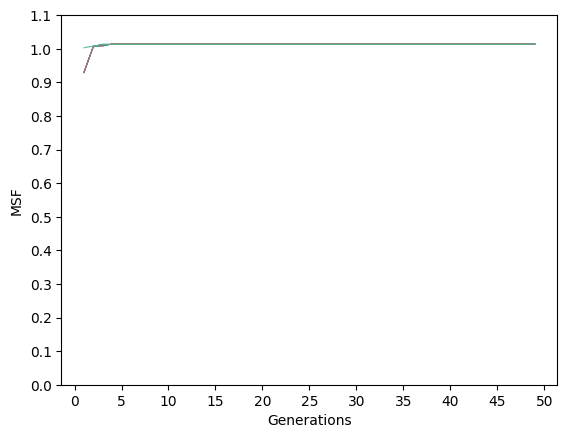

In [18]:
def basic_evolution(chosen_gate_set, MINIMUM_FITNESS=0.75):
    msf_trace = [[] for _ in range(SAMPLE_SIZE)]

    population = []
    while len(population) < SAMPLE_SIZE//2:
        for _ in range(GENERATION_SIZE):
            g = generate_random_genotype(3, chosen_gate_set, 30, 60)
            c = genotype_to_circuit(QuantumCircuit(3), g, chosen_gate_set)
            m = toffoli_msf(c)
            population.append({'genotype':g, 'circuit':c, 'msf':m})
        population = top_n_by_fitness(population)
        if population[-1]['msf'] >= MINIMUM_FITNESS:
            break
        else:
            for i in range(len(population)):
                if population[i]['msf'] < MINIMUM_FITNESS:
                    population = population[:i]
                    break
    print(f'Generation 1 Best Genotype: {population[0]["genotype"]}')
    print(f'Generation 1 Size: {len(population)}')

    for i in range(GENERATION_COUNT-1):
        new_population = develop_circuits_combined(population, chosen_gate_set)
        population = []
        for g in new_population:
            c = genotype_to_circuit(QuantumCircuit(3), g, chosen_gate_set)
            m = toffoli_msf(c)
            population.append({'genotype':g, 'circuit':c, 'msf':m})
        population = top_n_by_fitness(population, remove_dupe=False)
        while population[-1]['msf'] < MINIMUM_FITNESS:
            population.pop(-1)
        print(f'Generation {i+2} Best Genotype: {population[0]["genotype"]}')
        print(f'Generation {i+2} Best Fitness: {population[0]["msf"]}')
        for k in range(SAMPLE_SIZE):
            msf_trace[k].append(population[k]['msf'])

    # output
    print(f'Top {SAMPLE_SIZE} genotypes:')
    for i in range(SAMPLE_SIZE):
        print(population[i]['genotype'])
        print(population[i]['msf'])
    print('best circuit:')
    print(population[0]['circuit'])
    plot_list(msf_trace, 'Generations', 'MSF')

    return population


ALL_POSSIBLE_GATES = all_gate_combinations(GLOBAL_GATE_SET)
population = basic_evolution(GLOBAL_GATE_SET)


In [19]:
circuit = population[0]['circuit']
#circuit = genotype_to_circuit(QuantumCircuit(3),'317121210312101060221260221012701721')
print(circuit)

input_states = [list_to_state(x) for x in toffoli_inputs]
output_states = [list_to_state(y) for y in toffoli_outputs]

differences = {'global':0,'local':0}
M = Operator(circuit)
for i in range(len(input_states)):
    state = input_states[i]
    calc_state = state.evolve(M)
    print(f"target: {output_states[i].draw(output='latex_source')} --> actual: {calc_state.draw(output='latex_source')}")
    #output_states[i].draw(output='latex')
    if calc_state==output_states[i]:
        #print('exacly correct')
        pass
    else:
        if fidelity(output_states[i],calc_state.data)**2 == 1.0:
            print('state correct up to global phase')
            differences['global'] += 1
        else:
            #print('state incorrect')
            differences['local'] += 1

print(f"exactly correct for {8-differences['global']-differences['local']} states")
if differences['global']+differences['local'] != 0:
    print(f"correct (up to global phase) for {8-differences['local']} states")


NameError: name 'population' is not defined

d:\PROGRAMS\Python 3_9_5\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


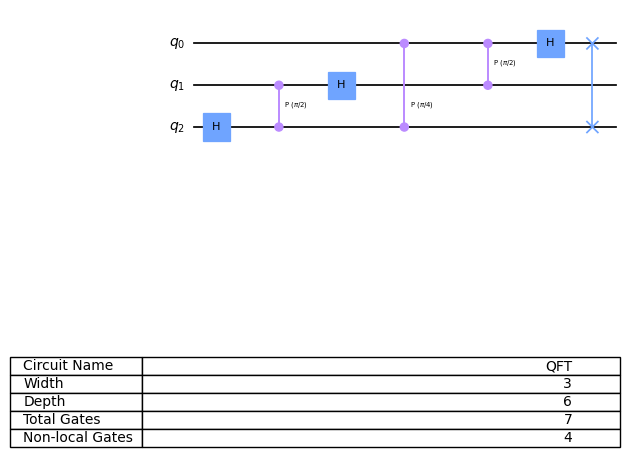

In [1]:
from qiskit.tools.jupyter.library import _generate_circuit_library_visualization
from qiskit.circuit.library import QFT
circuit = QFT(3)
_generate_circuit_library_visualization(circuit)

